<a href="https://colab.research.google.com/github/Sumudu01/CardioCare/blob/model/models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


Class balance (overall):
heart_attack
0    0.5
1    0.5
Name: proportion, dtype: Float64

=== Baseline (Majority Class) ===
Accuracy: 0.500
              precision    recall  f1-score   support

         0.0      0.500     1.000     0.667     15177
         1.0      0.000     0.000     0.000     15177

    accuracy                          0.500     30354
   macro avg      0.250     0.500     0.333     30354
weighted avg      0.250     0.500     0.333     30354



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


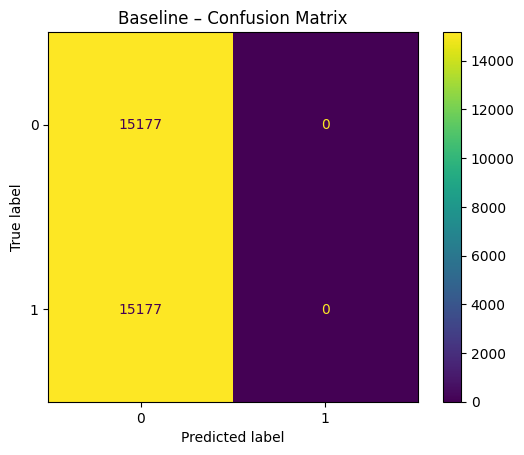


Baseline done.


In [ ]:
# BASELINE

#dataset path
DATA_PATH = "/content/heartAttack_clean.csv"

#Imports
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.dummy import DummyClassifier
from sklearn.metrics import (
    accuracy_score, classification_report, ConfusionMatrixDisplay
)

df = pd.read_csv(DATA_PATH)

# Drop accidental index cols like 'Unnamed: 0'
for c in list(df.columns):
    if re.fullmatch(r"unnamed:\s*0", str(c).strip(), flags=re.I):
        df = df.drop(columns=[c])

#Target detection & cleaning
def find_col(dataframe, candidates):
    cols_norm = {c: re.sub(r"\s+", "_", str(c)).strip().lower() for c in dataframe.columns}
    for orig, norm in cols_norm.items():
        if norm in candidates: return orig
    for orig, norm in cols_norm.items():
        if any(cand in norm for cand in candidates): return orig
    return None

target_candidates = {
    "heart_attack","heartattack","has_heart_attack","heart_disease",
    "target","label","outcome","disease","class"
}
target_col = find_col(df, target_candidates)
assert target_col is not None, f"Couldn't find target column. Rename label to one of: {sorted(target_candidates)}"

y_raw = df[target_col]
if not np.issubdtype(y_raw.dtype, np.number):
    mapping = {
        "yes":1,"y":1,"true":1,"present":1,"positive":1,"pos":1,"1":1,
        "no":0,"n":0,"false":0,"absent":0,"negative":0,"neg":0,"0":0
    }
    y = y_raw.astype(str).str.strip().str.lower().map(mapping)
else:
    y = y_raw.copy()
try: y = y.astype("Int64")
except: pass
uniq = pd.Series(y.dropna().unique())
assert pd.Series(uniq).isin([0,1]).all(), f"Target looks non-binary: {uniq.tolist()}"

X = df.drop(columns=[target_col])

#Train/test split
Xtr, Xte, ytr, yte = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print("\nClass balance (overall):")
print(y.value_counts(normalize=True).rename("proportion").round(3))

#Preprocessing (numeric + categorical)
num_cols = Xtr.select_dtypes(include=np.number).columns.tolist()
cat_cols = [c for c in Xtr.columns if c not in num_cols]

try:
    ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
except TypeError:
    ohe = OneHotEncoder(handle_unknown='ignore', sparse=False)

numeric_tf = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])
categorical_tf = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("ohe", ohe)
])

preprocessor = ColumnTransformer([
    ("num", numeric_tf, num_cols),
    ("cat", categorical_tf, cat_cols)
])

#Baseline model + evaluation
baseline = Pipeline([
    ("prep", preprocessor),
    ("clf", DummyClassifier(strategy="most_frequent"))
])

baseline.fit(Xtr, ytr)

yhat = baseline.predict(Xte)
acc = accuracy_score(yte, yhat)
print("\n=== Baseline (Majority Class) ===")
print(f"Accuracy: {acc:.3f}")
print(classification_report(yte, yhat, digits=3))
ConfusionMatrixDisplay.from_predictions(yte, yhat)
plt.title("Baseline – Confusion Matrix")
plt.show()
print("\nBaseline done.")



 Class balance (overall):
heart_attack
0    0.5
1    0.5
Name: proportion, dtype: Float64

=== Logistic Regression ===
Accuracy: 0.720
              precision    recall  f1-score   support

         0.0      0.709     0.745     0.727     15177
         1.0      0.731     0.694     0.712     15177

    accuracy                          0.720     30354
   macro avg      0.720     0.720     0.719     30354
weighted avg      0.720     0.720     0.719     30354



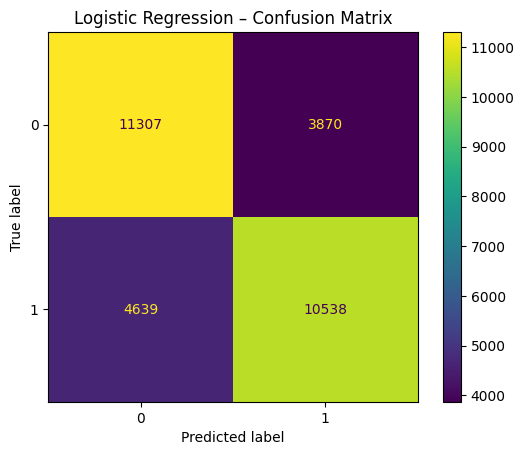

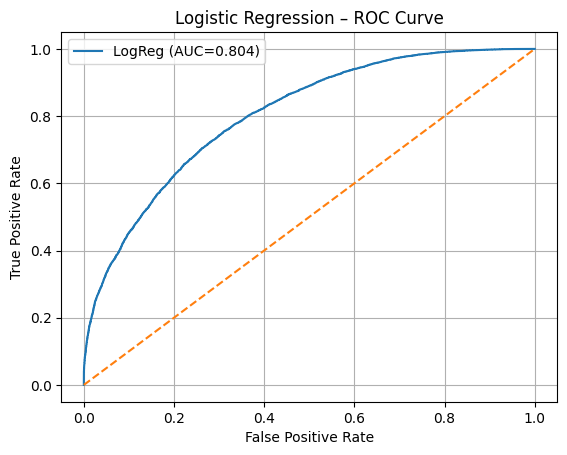


 Logistic Regression done.


In [ ]:
#LOGISTIC REGRESSION

DATA_PATH = "/content/heartAttack_clean.csv"  # <-- set your file path

#Imports
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, classification_report, roc_auc_score, roc_curve, ConfusionMatrixDisplay
)

df = pd.read_csv(DATA_PATH)

# Drop accidental index cols like 'Unnamed: 0'
for c in list(df.columns):
    if re.fullmatch(r"unnamed:\s*0", str(c).strip(), flags=re.I):
        df = df.drop(columns=[c])

#Target detection & cleaning
def find_col(dataframe, candidates):
    cols_norm = {c: re.sub(r"\s+", "_", str(c)).strip().lower() for c in dataframe.columns}
    for orig, norm in cols_norm.items():
        if norm in candidates: return orig
    for orig, norm in cols_norm.items():
        if any(cand in norm for cand in candidates): return orig
    return None

target_candidates = {
    "heart_attack","heartattack","has_heart_attack","heart_disease",
    "target","label","outcome","disease","class"
}
target_col = find_col(df, target_candidates)
assert target_col is not None, f"Couldn't find target column. Rename label to one of: {sorted(target_candidates)}"

y_raw = df[target_col]
if not np.issubdtype(y_raw.dtype, np.number):
    mapping = {
        "yes":1,"y":1,"true":1,"present":1,"positive":1,"pos":1,"1":1,
        "no":0,"n":0,"false":0,"absent":0,"negative":0,"neg":0,"0":0
    }
    y = y_raw.astype(str).str.strip().str.lower().map(mapping)
else:
    y = y_raw.copy()
try: y = y.astype("Int64")
except: pass
uniq = pd.Series(y.dropna().unique())
assert pd.Series(uniq).isin([0,1]).all(), f"Target looks non-binary: {uniq.tolist()}"

X = df.drop(columns=[target_col])

#Train/test split
Xtr, Xte, ytr, yte = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print("\n Class balance (overall):")
print(y.value_counts(normalize=True).rename("proportion").round(3))

# Preprocessing (numeric + categorical)
num_cols = Xtr.select_dtypes(include=np.number).columns.tolist()
cat_cols = [c for c in Xtr.columns if c not in num_cols]

try:
    ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
except TypeError:
    ohe = OneHotEncoder(handle_unknown='ignore', sparse=False)

numeric_tf = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])
categorical_tf = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("ohe", ohe)
])

preprocessor = ColumnTransformer([
    ("num", numeric_tf, num_cols),
    ("cat", categorical_tf, cat_cols)
])

#Logistic Regression + evaluation
logreg = Pipeline([
    ("prep", preprocessor),
    ("clf", LogisticRegression(max_iter=1000))
])

logreg.fit(Xtr, ytr)

yhat = logreg.predict(Xte)
acc = accuracy_score(yte, yhat)
print("\n=== Logistic Regression ===")
print(f"Accuracy: {acc:.3f}")
print(classification_report(yte, yhat, digits=3))
ConfusionMatrixDisplay.from_predictions(yte, yhat)
plt.title("Logistic Regression – Confusion Matrix")
plt.show()

# ROC-AUC
try:
    yproba = logreg.predict_proba(Xte)[:, 1]
    auc = roc_auc_score(yte, yproba)
    fpr, tpr, _ = roc_curve(yte, yproba)
    plt.plot(fpr, tpr, label=f"LogReg (AUC={auc:.3f})")
    plt.plot([0,1],[0,1], linestyle="--")
    plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
    plt.title("Logistic Regression – ROC Curve"); plt.legend(); plt.grid(True); plt.show()
except Exception as e:
    print(f"(No ROC-AUC shown: {e})")

print("\n Logistic Regression done.")


=== Decision Tree Report ===
              precision    recall  f1-score   support

           0       0.72      0.90      0.80     15177
           1       0.87      0.66      0.75     15177

    accuracy                           0.78     30354
   macro avg       0.80      0.78      0.78     30354
weighted avg       0.80      0.78      0.78     30354



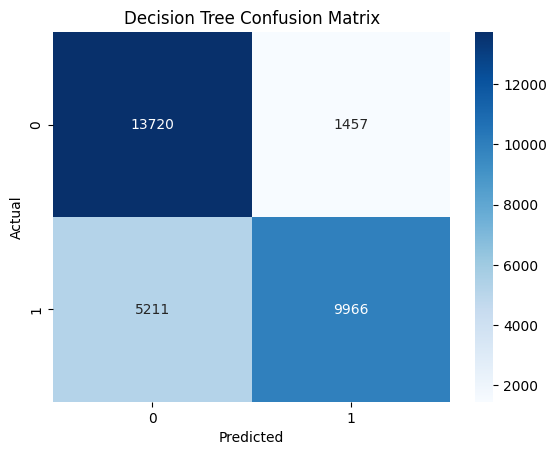

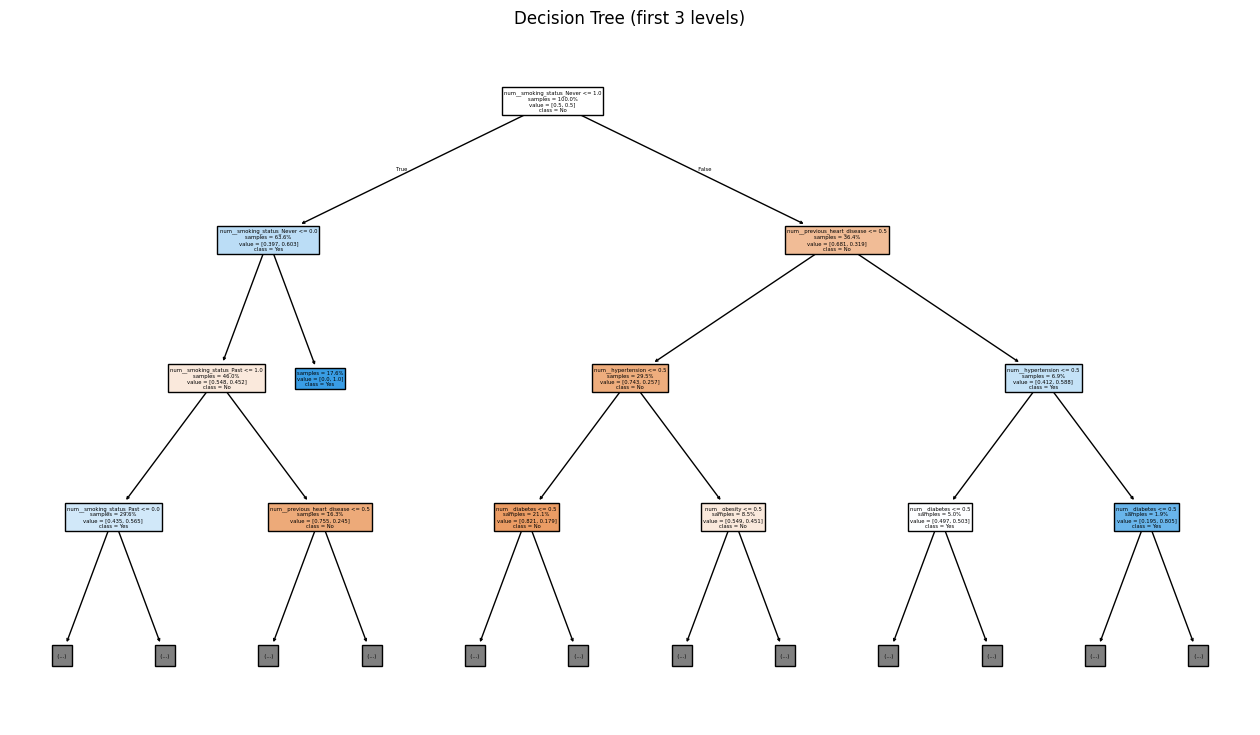

In [ ]:
#DECISION TREE

DATA_PATH = "/content/heartAttack_clean.csv"

#Imports
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.tree import DecisionTreeClassifier, plot_tree

#Load data
df = pd.read_csv(DATA_PATH)
for c in list(df.columns):
    if re.fullmatch(r"unnamed:\s*0", str(c).strip(), flags=re.I):
        df = df.drop(columns=[c])

#Detect binary target
def find_col(dataframe, candidates):
    norm = {c: re.sub(r"\s+", "_", str(c)).strip().lower() for c in dataframe.columns}
    for orig, n in norm.items():
        if n in candidates: return orig
    for orig, n in norm.items():
        if any(cand in n for cand in candidates): return orig
    return None

target_candidates = {
    "heart_attack","heartattack","has_heart_attack","heart_disease",
    "target","label","outcome","disease","class"
}
target_col = find_col(df, target_candidates)
assert target_col is not None, "Target/label column not found."

y_raw = df[target_col]
if not np.issubdtype(y_raw.dtype, np.number):
    mapping = {"yes":1,"y":1,"true":1,"present":1,"positive":1,"pos":1,"1":1,
               "no":0,"n":0,"false":0,"absent":0,"negative":0,"neg":0,"0":0}
    y = y_raw.astype(str).str.strip().str.lower().map(mapping)
else:
    y = y_raw.copy()
y = y.astype(int)

X = df.drop(columns=[target_col])

#Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

#Preprocessing
num_cols = X_train.select_dtypes(include=np.number).columns.tolist()
cat_cols = [c for c in X_train.columns if c not in num_cols]

# OneHotEncoder compatibility across sklearn versions
try:
    ohe = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
except TypeError:
    ohe = OneHotEncoder(handle_unknown="ignore", sparse=False)

preprocessor = ColumnTransformer([
    ("num", SimpleImputer(strategy="median"), num_cols),          # no scaler for tree
    ("cat", Pipeline([
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("ohe", ohe)
    ]), cat_cols)
])

#Fit Decision Tree
dt = Pipeline([
    ("prep", preprocessor),
    ("clf", DecisionTreeClassifier(random_state=42, max_depth=5))
])

dt.fit(X_train, y_train)
y_pred_dt = dt.predict(X_test)

print("=== Decision Tree Report ===")
print(classification_report(y_test, y_pred_dt))

#Confusion Matrix
cm = confusion_matrix(y_test, y_pred_dt)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Decision Tree Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

#Plot the tree with correct feature names
feature_names = None
try:
    feature_names = dt.named_steps["prep"].get_feature_names_out()
except Exception:
    feat_names_num = num_cols
    try:
        ohe_model = dt.named_steps["prep"].named_transformers_["cat"].named_steps["ohe"]
        feat_names_cat = list(ohe_model.get_feature_names_out(cat_cols))
    except Exception:
        feat_names_cat = [f"{c}_enc" for c in cat_cols]
    feature_names = list(feat_names_num) + list(feat_names_cat)

plt.figure(figsize=(16, 9))
plot_tree(
    dt.named_steps["clf"],
    feature_names=feature_names,
    class_names=["No", "Yes"],
    filled=True,
    max_depth=3,
    impurity=False,
    proportion=True
)
plt.title("Decision Tree (first 3 levels)")
plt.show()


=== Random Forest Report ===
              precision    recall  f1-score   support

           0       0.85      0.95      0.90     15177
           1       0.94      0.83      0.88     15177

    accuracy                           0.89     30354
   macro avg       0.89      0.89      0.89     30354
weighted avg       0.89      0.89      0.89     30354



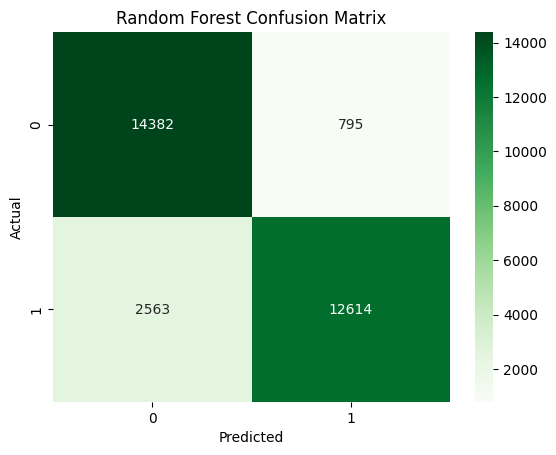

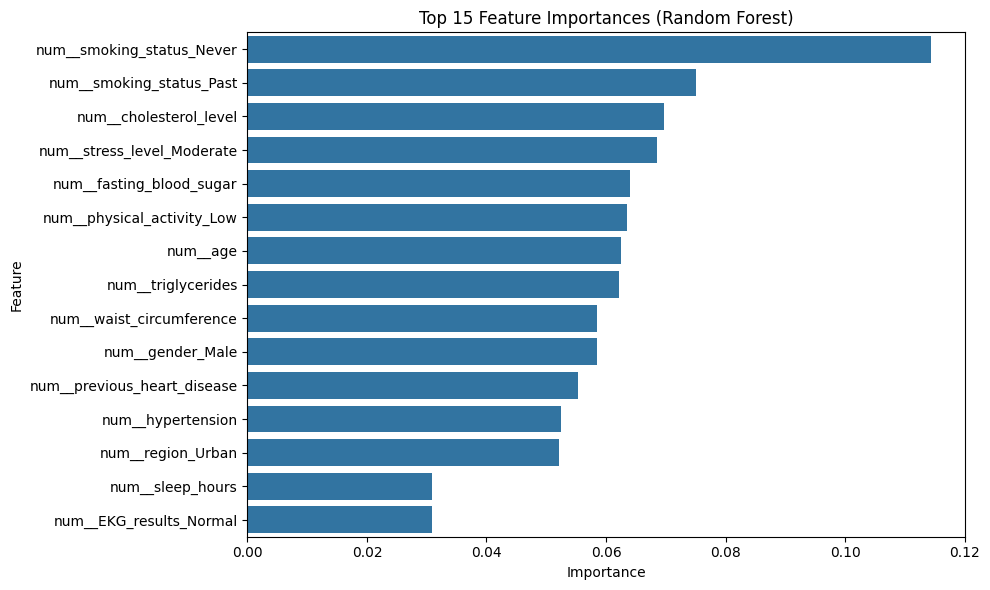

In [ ]:
#RANDOM FOREST

DATA_PATH = "/content/heartAttack_clean.csv"

#Imports
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier

#Load data
df = pd.read_csv(DATA_PATH)
for c in list(df.columns):
    if re.fullmatch(r"unnamed:\s*0", str(c).strip(), flags=re.I):
        df = df.drop(columns=[c])

#Detect binary target
def find_col(dataframe, candidates):
    norm = {c: re.sub(r"\s+", "_", str(c)).strip().lower() for c in dataframe.columns}
    for orig, n in norm.items():
        if n in candidates: return orig
    for orig, n in norm.items():
        if any(cand in n for cand in candidates): return orig
    return None

target_candidates = {
    "heart_attack","heartattack","has_heart_attack","heart_disease",
    "target","label","outcome","disease","class"
}
target_col = find_col(df, target_candidates)
assert target_col is not None, "Target/label column not found."

y_raw = df[target_col]
if not np.issubdtype(y_raw.dtype, np.number):
    mapping = {"yes":1,"y":1,"true":1,"present":1,"positive":1,"pos":1,"1":1,
               "no":0,"n":0,"false":0,"absent":0,"negative":0,"neg":0,"0":0}
    y = y_raw.astype(str).str.strip().str.lower().map(mapping)
else:
    y = y_raw.copy()
y = y.astype(int)

X = df.drop(columns=[target_col])

#Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

#Preprocessing
num_cols = X_train.select_dtypes(include=np.number).columns.tolist()
cat_cols = [c for c in X_train.columns if c not in num_cols]

# OneHotEncoder compatibility across sklearn versions
try:
    ohe = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
except TypeError:
    ohe = OneHotEncoder(handle_unknown="ignore", sparse=False)

preprocessor = ColumnTransformer([
    ("num", SimpleImputer(strategy="median"), num_cols),
    ("cat", Pipeline(steps=[
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("ohe", ohe)
    ]), cat_cols),
])

rf = Pipeline([
    ("prep", preprocessor),
    ("clf", RandomForestClassifier(n_estimators=100, random_state=42))
])

rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

print("=== Random Forest Report ===")
print(classification_report(y_test, y_pred_rf))

#Confusion Matrix
cm = confusion_matrix(y_test, y_pred_rf)
sns.heatmap(cm, annot=True, fmt="d", cmap="Greens")
plt.title("Random Forest Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

#Feature Importances
try:
    feature_names = rf.named_steps["prep"].get_feature_names_out()
except Exception:
    feat_names_num = num_cols
    try:
        ohe_model = rf.named_steps["prep"].named_transformers_["cat"].named_steps["ohe"]
        feat_names_cat = list(ohe_model.get_feature_names_out(cat_cols))
    except Exception:
        feat_names_cat = [f"{c}_enc" for c in cat_cols]
    feature_names = list(feat_names_num) + list(feat_names_cat)

importances = pd.Series(rf.named_steps["clf"].feature_importances_, index=feature_names)\
               .sort_values(ascending=False)

TOP_N = 15
plt.figure(figsize=(10, 6))
sns.barplot(x=importances.head(TOP_N).values, y=importances.head(TOP_N).index)
plt.title(f"Top {TOP_N} Feature Importances (Random Forest)")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()


In [ ]:
#SVM (RBF)

# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

df = pd.read_csv("/content/heartAttack_clean.csv")

# Separate features (X) and target (y)
X = df.drop('heart_attack', axis=1)
y = df['heart_attack']

# Identify categorical features and apply One-Hot Encoding
categorical_cols = X.select_dtypes(include=['object']).columns
X_encoded = pd.get_dummies(X, columns=categorical_cols, drop_first=True)
target_names = ['No Attack', 'Heart Attack']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.3, random_state=42, stratify=y)

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"  Data loaded and preprocessed. Total features: {X_train_scaled.shape[1]}")
print("---------------------------------------")

#Train and Evaluate Support Vector Machine (SVM)

print(" Training Support Vector Machine (SVM)")

# Create and train the SVM model (using Radial Basis Function kernel)
svm_model = SVC(kernel='rbf', random_state=42)
svm_model.fit(X_train_scaled, y_train)

# Make predictions on the test set
svm_y_pred = svm_model.predict(X_test_scaled)

# Calculate metrics for SVM (using 'weighted' average for robust summary)
svm_accuracy = accuracy_score(y_test, svm_y_pred)
svm_precision_weighted = precision_score(y_test, svm_y_pred, average='weighted')
svm_recall_weighted = recall_score(y_test, svm_y_pred, average='weighted')
svm_f1_weighted = f1_score(y_test, svm_y_pred, average='weighted')

print("\nSVM Model Evaluation")
print(f"Accuracy: {svm_accuracy:.4f}")
print(f"Precision (weighted): {svm_precision_weighted:.4f}")
print(f"Recall (weighted): {svm_recall_weighted:.4f}")
print(f"F1-Score (weighted): {svm_f1_weighted:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, svm_y_pred, target_names=target_names, zero_division=0))
print("---------------------------------------")


  Data loaded and preprocessed. Total features: 21
---------------------------------------
 Training Support Vector Machine (SVM)

SVM Model Evaluation
Accuracy: 0.8563
Precision (weighted): 0.8665
Recall (weighted): 0.8563
F1-Score (weighted): 0.8553

Classification Report:
              precision    recall  f1-score   support

   No Attack       0.81      0.94      0.87     22766
Heart Attack       0.93      0.77      0.84     22765

    accuracy                           0.86     45531
   macro avg       0.87      0.86      0.86     45531
weighted avg       0.87      0.86      0.86     45531

---------------------------------------


In [ ]:
#NEURAL NETWORK ONLY

# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

df = pd.read_csv("/content/heartAttack_clean.csv")

# Separate features (X) and target (y)
X = df.drop('heart_attack', axis=1)
y = df['heart_attack']

# Identify categorical features and apply One-Hot Encoding
categorical_cols = X.select_dtypes(include=['object']).columns
X_encoded = pd.get_dummies(X, columns=categorical_cols, drop_first=True)
target_names = ['No Attack', 'Heart Attack']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.3, random_state=42, stratify=y)

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"  Data loaded and preprocessed. Total features: {X_train_scaled.shape[1]}")

#Train and Evaluate Neural Network (NN)
print(" Training Neural Network (NN) - Simple Multi-Layer Perceptron (Binary)...")

# Define the Neural Network model for binary classification
nn_model = Sequential([
    Dense(32, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    Dense(16, activation='relu'),
    Dense(1, activation='sigmoid')
])

# Compile the model
nn_model.compile(optimizer='adam',
                 loss='binary_crossentropy',
                 metrics=['accuracy'])

# Train the model (50 epochs)
history = nn_model.fit(X_train_scaled, y_train,
                       epochs=50,
                       batch_size=32,
                       validation_split=0.1,
                       verbose=0)

nn_y_prob = nn_model.predict(X_test_scaled, verbose=0)
nn_y_pred = (nn_y_prob > 0.5).astype(int)

# Calculate metrics for NN
nn_accuracy = accuracy_score(y_test, nn_y_pred)
nn_precision_weighted = precision_score(y_test, nn_y_pred, average='weighted', zero_division=0)
nn_recall_weighted = recall_score(y_test, nn_y_pred, average='weighted', zero_division=0)
nn_f1_weighted = f1_score(y_test, nn_y_pred, average='weighted', zero_division=0)

print("\n--- Neural Network Model Evaluation ---")
print(f"Accuracy: {nn_accuracy:.4f}")
print(f"Precision (weighted): {nn_precision_weighted:.4f}")
print(f"Recall (weighted): {nn_recall_weighted:.4f}")
print(f"F1-Score (weighted): {nn_f1_weighted:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, nn_y_pred, target_names=target_names, zero_division=0))



In [ ]:
# One split for ALL models + PR-AUC comparison

DATA_PATH = "/content/heartAttack_clean.csv"
TARGET_COL = "heart_attack"
TEST_SIZE   = 0.30
RANDOM_STATE = 42

import numpy as np, pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, f1_score, recall_score, classification_report,
    average_precision_score, precision_recall_curve
)
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

# Load & encode once
df = pd.read_csv(DATA_PATH).copy()
X = df.drop(columns=[TARGET_COL])
y = df[TARGET_COL].astype(int)

# One-hot encode categoricals once so all models see the same features
X = pd.get_dummies(X, drop_first=True)

# Single, consistent split for ALL models
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=y
)

# Scaled copies (for Logistic/SVM/NN)
scaler = StandardScaler(with_mean=True, with_std=True)
X_train_s = scaler.fit_transform(X_train)
X_test_s  = scaler.transform(X_test)

# --- Helper to evaluate with PR-AUC ---
def eval_and_row(name, y_true, y_pred, scores_for_prauc):
    acc = accuracy_score(y_true, y_pred)
    f1w = f1_score(y_true, y_pred, average="weighted", zero_division=0)
    rec_pos = recall_score(y_true, y_pred, pos_label=1, zero_division=0)
    pr_auc = average_precision_score(y_true, scores_for_prauc)  # PR-AUC (Average Precision)
    return dict(Model=name, Accuracy=acc, F1_weighted=f1w, Recall_pos=rec_pos, PR_AUC=pr_auc)

rows = []

# 1) Baseline (majority)
base = DummyClassifier(strategy="most_frequent")
base.fit(X_train, y_train)
yhat = base.predict(X_test)
# For PR-AUC we need scores; use a constant 0 vector => AP equals prevalence
scores = np.zeros_like(y_test, dtype=float)
rows.append(eval_and_row("Baseline (majority)", y_test, yhat, scores))

# 2) Logistic Regression
logreg = LogisticRegression(max_iter=1000, random_state=RANDOM_STATE)
logreg.fit(X_train_s, y_train)
yhat = logreg.predict(X_test_s)
scores = logreg.predict_proba(X_test_s)[:, 1]
rows.append(eval_and_row("Logistic Regression", y_test, yhat, scores))

# 3) Decision Tree
dt = DecisionTreeClassifier(random_state=RANDOM_STATE, max_depth=5)
dt.fit(X_train, y_train)
yhat = dt.predict(X_test)
# Use predicted probability for class 1 for PR-AUC
scores = dt.predict_proba(X_test)[:, 1]
rows.append(eval_and_row("Decision Tree", y_test, yhat, scores))

# 4) Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=RANDOM_STATE)
rf.fit(X_train, y_train)
yhat = rf.predict(X_test)
scores = rf.predict_proba(X_test)[:, 1]
rows.append(eval_and_row("Random Forest", y_test, yhat, scores))

# 5) SVM (RBF) – use decision_function (no need for probability=True)
svm = SVC(kernel="rbf", random_state=RANDOM_STATE)
svm.fit(X_train_s, y_train)
yhat = svm.predict(X_test_s)
scores = svm.decision_function(X_test_s)  # acceptable for PR-AUC
rows.append(eval_and_row("SVM (RBF)", y_test, yhat, scores))

# 6) Neural Network (simple MLP)
tf.keras.utils.set_random_seed(RANDOM_STATE)
nn = Sequential([
    Dense(32, activation="relu", input_shape=(X_train_s.shape[1],)),
    Dense(16, activation="relu"),
    Dense(1, activation="sigmoid")
])
nn.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
_ = nn.fit(X_train_s, y_train, epochs=50, batch_size=32, validation_split=0.1, verbose=0)

proba = nn.predict(X_test_s, verbose=0).ravel()
yhat = (proba > 0.5).astype(int)
rows.append(eval_and_row("Neural Network (MLP)", y_test, yhat, proba))

# --- Summary tables ---
summary = pd.DataFrame(rows)
print("\n=== Comparison (sorted by PR-AUC) ===")
print(summary.sort_values("PR_AUC", ascending=False).round(4).reset_index(drop=True))

print("\n=== Also sorted by Accuracy ===")
print(summary.sort_values("Accuracy", ascending=False).round(4).reset_index(drop=True))


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



=== Comparison (sorted by PR-AUC) ===
                  Model  Accuracy  F1_weighted  Recall_pos  PR_AUC
0   Logistic Regression    0.8215       0.7956      0.3152  0.5651
1         Random Forest    0.8209       0.7826      0.2382  0.5561
2  Neural Network (MLP)    0.8160       0.7886      0.2974  0.5416
3             SVM (RBF)    0.8154       0.7726      0.2079  0.5249
4         Decision Tree    0.8170       0.7794      0.2366  0.5203
5   Baseline (majority)    0.7888       0.6956      0.0000  0.2112

=== Also sorted by Accuracy ===
                  Model  Accuracy  F1_weighted  Recall_pos  PR_AUC
0   Logistic Regression    0.8215       0.7956      0.3152  0.5651
1         Random Forest    0.8209       0.7826      0.2382  0.5561
2         Decision Tree    0.8170       0.7794      0.2366  0.5203
3  Neural Network (MLP)    0.8160       0.7886      0.2974  0.5416
4             SVM (RBF)    0.8154       0.7726      0.2079  0.5249
5   Baseline (majority)    0.7888       0.6956      0.000